In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from medmnist import PathMNIST
from medmnist import INFO

In [2]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.2])
])

train_dataset = PathMNIST(split='train', download=True, transform=data_transform)
val_dataset = PathMNIST(split='val', download=False, transform=data_transform)
test_dataset = PathMNIST(split='test', download=False, transform=data_transform)

Using downloaded and verified file: C:\Users\jaint\.medmnist\pathmnist.npz


In [3]:
info = INFO['pathmnist']  # get some metadata of PathMNIST

batch_size = 32
n_channels, n_classes = info['n_channels'], len(info['label'])

In [4]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*batch_size, shuffle=False)

In [5]:
print(next(iter(train_loader)))

[tensor([[[[-0.3431, -0.2451, -0.2843,  ..., -0.2059, -0.1471, -0.0686],
          [-0.2843, -0.2647, -0.3039,  ..., -0.2255, -0.2451, -0.1667],
          [-0.2451, -0.3235, -0.3431,  ..., -0.2255, -0.2843, -0.2647],
          ...,
          [-0.3431, -0.3824, -0.4020,  ..., -0.1471, -0.0686, -0.1275],
          [-0.3039, -0.3824, -0.4020,  ..., -0.1863, -0.0686, -0.1275],
          [-0.3235, -0.3431, -0.4216,  ..., -0.1471, -0.1863, -0.1863]],

         [[-1.3824, -1.3431, -1.4216,  ..., -1.3431, -1.3039, -1.2255],
          [-1.3431, -1.3627, -1.4020,  ..., -1.3627, -1.4020, -1.3039],
          [-1.3235, -1.3824, -1.4216,  ..., -1.3235, -1.3824, -1.3627],
          ...,
          [-1.4216, -1.5000, -1.5588,  ..., -1.2059, -1.1275, -1.2059],
          [-1.4216, -1.5196, -1.5784,  ..., -1.2451, -1.1078, -1.1863],
          [-1.4020, -1.4020, -1.5196,  ..., -1.2255, -1.2451, -1.2451]],

         [[-0.1863, -0.2255, -0.3431,  ..., -0.1667, -0.1078, -0.0294],
          [-0.1667, -0.2451, 

In [6]:
print(n_channels, n_classes)

3 9


In [7]:
class PathNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(PathNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=5),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())

        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU())

        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU())

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.2)

        self.fc1 = nn.Sequential(nn.Linear(in_features=64 * 8 * 8, out_features=512), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(in_features=512, out_features=128), nn.ReLU())
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool((self.conv4(x)))

        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x  # not applying softmax


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PathNet(n_channels, n_classes).to(device)
criterion = nn.CrossEntropyLoss()

In [9]:
num_epochs = 8
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

total_steps = len(train_loader)
losses = []
for epoch in range(num_epochs):
    if (epoch + 1) % 2 == 0:
        learning_rate *= 0.5
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print('========= Epoch:', epoch + 1, "===========")
    train_loss = 0
    model.train()

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.view(-1).long().to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    losses.append(train_loss)

    model.eval()  # disable batch norm & dropout
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.view(-1).to(device)
            outputs = model(images)

            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += torch.eq(predicted, labels).sum().item()

    acc = correct / total
    print(f'Accuracy: {100 * acc:.2f}%')
    print(f"Loss: {train_loss}")

print('Finished Training')

========= Epoch: 1 ===========


100%|██████████| 2813/2813 [00:27<00:00, 103.00it/s]


Accuracy: 48.77%
Loss: 1.3502479796514704
========= Epoch: 2 ===========


100%|██████████| 2813/2813 [00:26<00:00, 106.77it/s]


Accuracy: 73.94%
Loss: 0.9417217226796332
========= Epoch: 3 ===========


100%|██████████| 2813/2813 [00:25<00:00, 110.35it/s]


Accuracy: 76.17%
Loss: 0.7799696885857174
========= Epoch: 4 ===========


100%|██████████| 2813/2813 [00:25<00:00, 111.54it/s]


Accuracy: 79.98%
Loss: 0.645336241954974
========= Epoch: 5 ===========


100%|██████████| 2813/2813 [00:25<00:00, 110.60it/s]


Accuracy: 84.31%
Loss: 0.5872926968528925
========= Epoch: 6 ===========


100%|██████████| 2813/2813 [00:25<00:00, 109.94it/s]


Accuracy: 85.98%
Loss: 0.5111937356104301
========= Epoch: 7 ===========


100%|██████████| 2813/2813 [00:25<00:00, 110.31it/s]


Accuracy: 85.51%
Loss: 0.48295472876969664
========= Epoch: 8 ===========


100%|██████████| 2813/2813 [00:25<00:00, 111.38it/s]


Accuracy: 86.99%
Loss: 0.44838304554403274
Finished Training


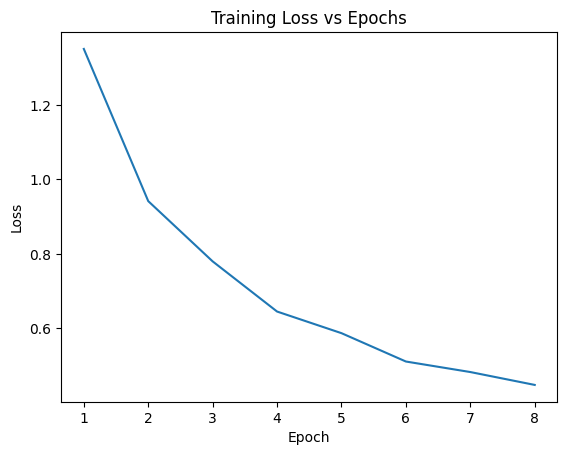

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.view(-1).to(device)
        outputs = model(images)

        predicted = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += torch.eq(predicted, labels).sum().item()

    acc = correct / total
    print(f'Accuracy: {100 * acc:.2f}%')

Accuracy: 77.49%


In [12]:
torch.save(model.state_dict(), 'trained_model.pth')